In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from mlxtend.feature_selection import SequentialFeatureSelector, ExhaustiveFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Multilinear Regression
from sklearn import linear_model

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# ANN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD

# SVMD
from sklearn.svm import SVC

# Read CSV
stroke_data = pd.read_csv(r'C:\Users\ngbow\OneDrive - Asia Pacific University\Semester 4\CT032 - FAI\Group Work\healthcare-dataset-stroke-data.csv');

In [2]:
stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
stroke_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
stroke_data['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [5]:
stroke_data['gender'].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [6]:
# Change "Other" in gender to "Male"
stroke_data['gender'] = stroke_data['gender'].replace('Other', 'Male')

In [7]:
# Calculate mean BMI for each stroke category
mean_bmi_stroke_0 = stroke_data[stroke_data['stroke'] == 0]['bmi'].mean()
mean_bmi_stroke_1 = stroke_data[stroke_data['stroke'] == 1]['bmi'].mean()

# Fill missing BMI values based on stroke category
stroke_data.loc[stroke_data['stroke'] == 0, 'bmi'] = stroke_data[stroke_data['stroke'] == 0]['bmi'].fillna(mean_bmi_stroke_0)
stroke_data.loc[stroke_data['stroke'] == 1, 'bmi'] = stroke_data[stroke_data['stroke'] == 1]['bmi'].fillna(mean_bmi_stroke_1)

In [8]:
stroke_data['smoking_status'].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

In [9]:
# Function to replace 'Unknown' smoking_status based on stroke category ratio
def impute_unknown_smoking_status(data):
    for stroke_value in [0, 1]:
        stroke_data = data[data['stroke'] == stroke_value]
        known_smoking_status = stroke_data[stroke_data['smoking_status'] != 'Unknown']['smoking_status']
        unknown_smoking_status_count = stroke_data[stroke_data['smoking_status'] == 'Unknown'].shape[0]

        if unknown_smoking_status_count > 0:
            ratios = known_smoking_status.value_counts(normalize=True)
            ratios = ratios.reindex(['never smoked', 'formerly smoked', 'smokes'], fill_value=0)

            num_never_smoked = int(ratios['never smoked'] * unknown_smoking_status_count)
            num_formerly_smoked = int(ratios['formerly smoked'] * unknown_smoking_status_count)
            num_smokes = unknown_smoking_status_count - (num_never_smoked + num_formerly_smoked)

            replacements = (
                ['never smoked'] * num_never_smoked +
                ['formerly smoked'] * num_formerly_smoked +
                ['smokes'] * num_smokes
            )

            np.random.shuffle(replacements)

            data.loc[(data['stroke'] == stroke_value) & (data['smoking_status'] == 'Unknown'), 'smoking_status'] = replacements

    return data

# Imput 'Unknown' smoking_status
stroke_data = impute_unknown_smoking_status(stroke_data)

In [10]:
unknown_count = stroke_data[stroke_data['smoking_status'] == 'Unknown'].shape[0]
print(f"Number of rows where smoking_status is 'Unknown': {unknown_count}")

Number of rows where smoking_status is 'Unknown': 0


In [11]:
# Encode categorical variables
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
stroke_data = pd.get_dummies(stroke_data, columns=categorical_features, drop_first=True)

In [12]:
stroke_data.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.600000,1,True,True,False,True,False,False,True,False,False
1,51676,61.0,0,0,202.21,30.471292,1,False,True,False,False,True,False,False,True,False
2,31112,80.0,0,1,105.92,32.500000,1,True,True,False,True,False,False,False,True,False
3,60182,49.0,0,0,171.23,34.400000,1,False,True,False,True,False,False,True,False,True
4,1665,79.0,1,0,174.12,24.000000,1,False,True,False,False,True,False,False,True,False


In [13]:
# Separate features and target variable
X = stroke_data.drop(columns=['id', 'stroke'])
y = stroke_data['stroke']

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [15]:
# Apply SMOTE to the training set only
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

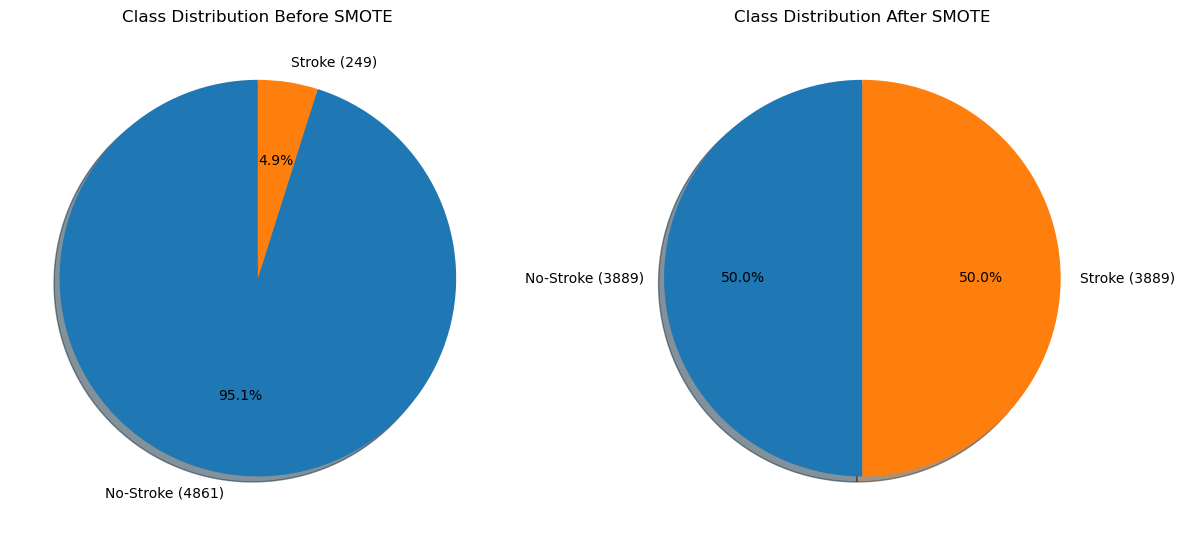

In [16]:
# Calculate the class proportions
original_counts = y.value_counts()
smote_counts = y_train_resampled.value_counts()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for original data
labels_original = [f"No-Stroke ({original_counts[0]})", f"Stroke ({original_counts[1]})"]
axs[0].pie(original_counts, labels=labels_original, autopct='%1.1f%%', shadow=True, startangle=90)
axs[0].set_title("Class Distribution Before SMOTE")

# Pie chart for SMOTE data
labels_smote = [f"No-Stroke ({smote_counts[0]})", f"Stroke ({smote_counts[1]})"]
axs[1].pie(smote_counts, labels=labels_smote, autopct='%1.1f%%', shadow=True, startangle=90)
axs[1].set_title("Class Distribution After SMOTE")

plt.tight_layout()
plt.show()

In [17]:
# Feature Selection
clf = RandomForestClassifier(n_jobs=-1)
efs = ExhaustiveFeatureSelector(clf,
                                min_features = 1,
                               max_features = 10,
                               scoring = "f1",
                               cv=2,
                               n_jobs=-1,
                               feature_groups = [[0], [1], [2], [3], [4], [5], [6], [7, 8, 9, 10], [11], [12, 13]])
efs.fit(X_train_resampled, y_train_resampled) # Fit the feature selection model with x_train and y_train

# Identify the important feature names
important_feature_names = efs.best_feature_names_
print("Best features:\n ", important_feature_names)
print("Model Best Score:\n ", efs.best_score_)

Features: 1023/1023

Best features:
  ('age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_Male', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_never smoked', 'smoking_status_smokes')
Model Best Score:
  0.9417300136310592


In [18]:
# Select features
selected_features = np.array(important_feature_names)
feature_count = len(selected_features)
print("Number of Features:\n ", feature_count)
X = stroke_data[selected_features]
y = stroke_data['stroke']

Number of Features:
  13


In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [20]:
# Apply SMOTE to the training set only
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2)

In [21]:
# Standardize the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test_resampled = scaler.transform(X_test_resampled)

Model with params: {'fit_intercept': True} Evaluation Metrics
Accuracy: 0.8618
Precision: 0.8529
Recall: 0.8857
F1 Score: 0.8690


Model with params: {'fit_intercept': False} Evaluation Metrics
Accuracy: 0.5900
Precision: 1.0000
Recall: 0.2075
F1 Score: 0.3436




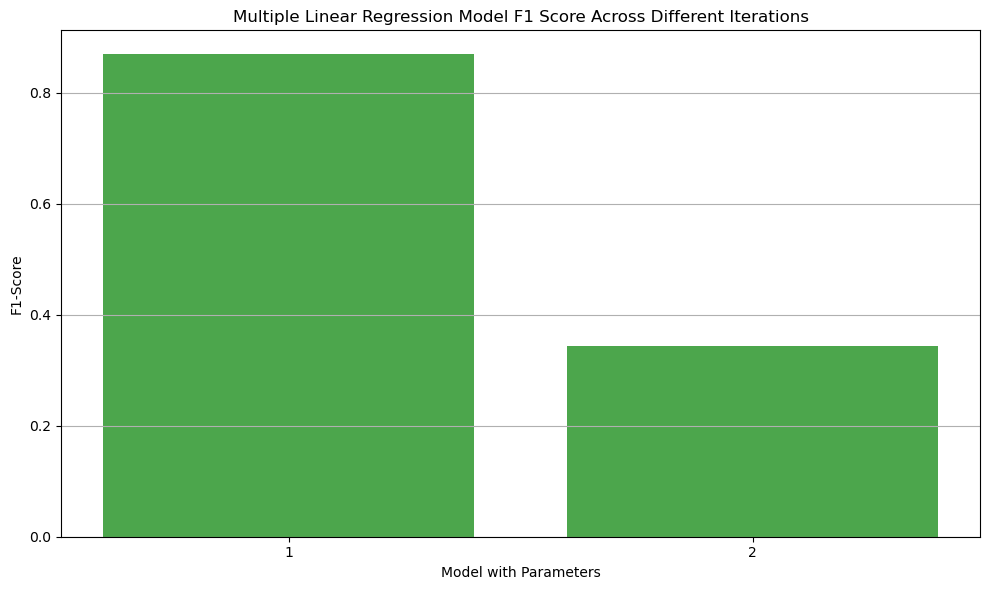

In [22]:
# Define the hyperparameters to test
hyperparameters = [{'fit_intercept': True}, {'fit_intercept': False}]

# Initialize a dictionary to store models and their corresponding metrics
metrics_dictionary = {}

# Iterate over the parameter grid to store each trained model
for params in hyperparameters:
    model = linear_model.LinearRegression(**params)
    model.fit(X_train_resampled, y_train_resampled)
    description = f"Model with params: {params}"

    # Evaluate the model
    y_prob = model.predict(X_test_resampled)
    y_pred = (y_prob > 0.5).astype(int)

    accuracy = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred)
    recall = recall_score(y_test_resampled, y_pred)
    f1 = f1_score(y_test_resampled, y_pred)

    # Store evaluation metrics in the metrics dictionary
    metrics_dictionary[description] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    
    print(f"{description} Evaluation Metrics")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\n")


# Convert results to a DataFrame
metrics_df = pd.DataFrame(metrics_dictionary).T

# Plotting the f1-scores across iterations using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(metrics_df) + 1), metrics_df['F1 Score'], color='g', alpha=0.7)
 
plt.title('Multiple Linear Regression Model F1 Score Across Different Iterations')
plt.xlabel('Model with Parameters')
plt.ylabel('F1-Score')
plt.xticks(range(1, len(metrics_df) + 1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [23]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [64, 100, 128, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='f1')

# Fit the Grid Search on the resampled and standardized training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Print the best parameters found by the grid search
print("Best Parameters:", grid_search.best_params_)

# Predict on the test set using the best model
y_pred = best_rf_model.predict(X_test_resampled)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_resampled, y_pred)
precision = precision_score(y_test_resampled, y_pred)
recall = recall_score(y_test_resampled, y_pred)
f1 = f1_score(y_test_resampled, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best Parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.9589
Precision: 0.9580
Recall: 0.9627
F1 Score: 0.9603


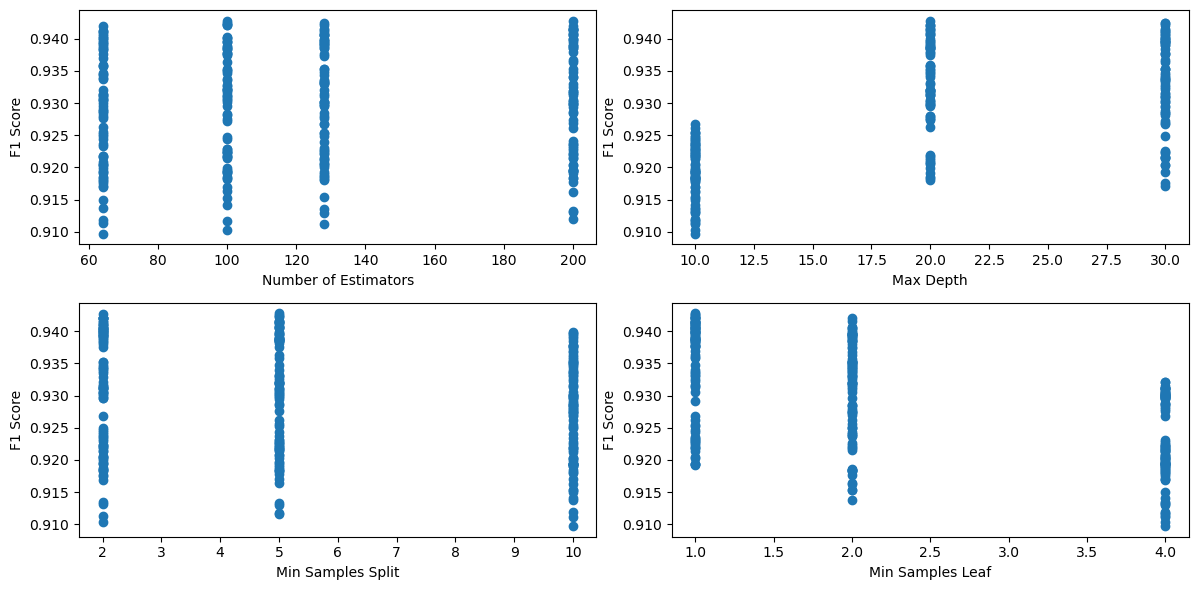

In [24]:
# Extract hyperparameters and F1 scores
hyperparameters = grid_search.cv_results_['params']
f1_scores = grid_search.cv_results_['mean_test_score']

# Extract hyperparameter values
n_estimators = [params['n_estimators'] for params in hyperparameters]
max_depth = [params['max_depth'] for params in hyperparameters]
min_samples_split = [params['min_samples_split'] for params in hyperparameters]
min_samples_leaf = [params['min_samples_leaf'] for params in hyperparameters]
bootstrap = [params['bootstrap'] for params in hyperparameters]

# Create plots
plt.figure(figsize=(12, 6))

# Plot F1 score against number of estimators
plt.subplot(2, 2, 1)
plt.scatter(n_estimators, f1_scores)
plt.xlabel('Number of Estimators')
plt.ylabel('F1 Score')

# Plot F1 score against max depth
plt.subplot(2, 2, 2)
plt.scatter(max_depth, f1_scores)
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')

# Plot F1 score against min samples split
plt.subplot(2, 2, 3)
plt.scatter(min_samples_split, f1_scores)
plt.xlabel('Min Samples Split')
plt.ylabel('F1 Score')

# Plot F1 score against min samples leaf
plt.subplot(2, 2, 4)
plt.scatter(min_samples_leaf, f1_scores)
plt.xlabel('Min Samples Leaf')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

Running GridSearchCV for iteration 1
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best estimator for iteration 1: SVC(C=10, gamma=1)
Running GridSearchCV for iteration 2
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best estimator for iteration 2: SVC(C=1, gamma=0.01)
Running GridSearchCV for iteration 3
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best estimator for iteration 3: SVC(C=1000, degree=4, gamma=0.1, kernel='poly')
Running GridSearchCV for iteration 4
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best estimator for iteration 4: SVC(C=10, gamma=0.001, kernel='sigmoid')


Iteration 1 - Best SVM Evaluation Metrics
Accuracy: 0.9357
Precision: 0.9242
Recall: 0.9540
F1 Score: 0.9389


Iteration 2 - Best SVM Evaluation Metrics
Accuracy: 0.8695
Precision: 0.8583
Recall: 0.8957
F1 Score: 0.8766


Iteration 3 - Best SVM Evaluation Metrics
Accuracy: 0.9126
Precision: 0.9006
Recall: 0.9342
F1 Score: 0.9171


Iteration 4 - Be

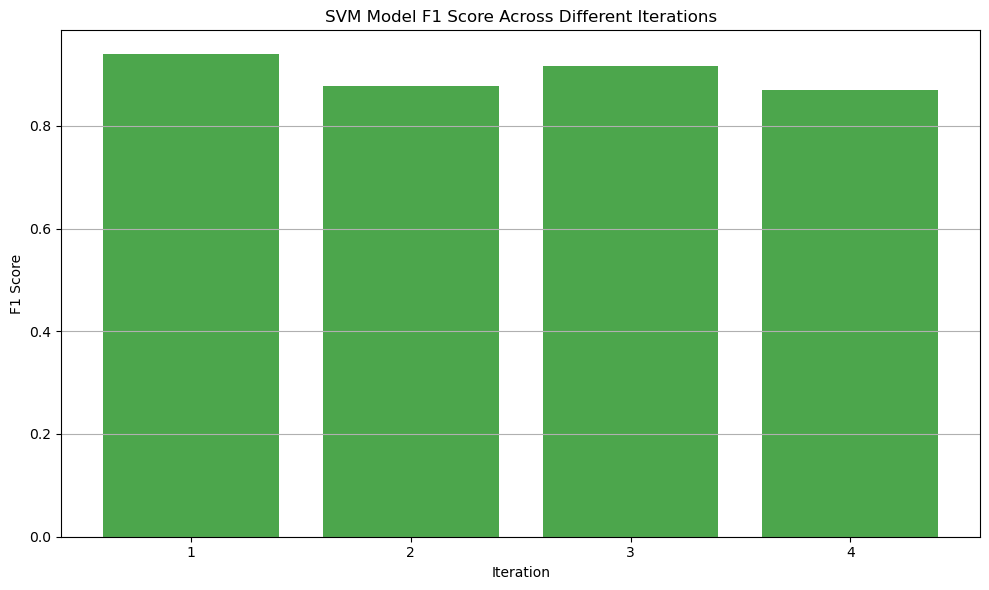

In [25]:
# Initialize the SVM model
svm = SVC()

# Define the different parameter grids
param_grids = [
    {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['linear', 'rbf']
    },
    {
        'C': [0.01, 0.1, 1],
        'gamma': [0.01, 0.001, 0.0001],
        'kernel': ['rbf']
    },
    {
        'C': [10, 100, 1000],
        'gamma': [0.1, 0.01, 0.001],
        'kernel': ['poly'],
        'degree': [2, 3, 4]
    },
    {
        'C': [1, 10, 100],
        'gamma': [0.1, 0.01, 0.001],
        'kernel': ['sigmoid']
    }
]

# Declare array to store final f1-score results
results = []
best_estimators = []

# Iterate over the parameter grids
for i, param_grid in enumerate(param_grids):
    print(f"Running GridSearchCV for iteration {i+1}")
    grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_estimators.append(grid_search.best_estimator_)
    print(f"Best estimator for iteration {i+1}: {grid_search.best_estimator_}")

print("\n")

# Evaluate each best estimator on the test set
for i, best_svm in enumerate(best_estimators):
    y_pred = best_svm.predict(X_test_resampled)
    accuracy = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred)
    recall = recall_score(y_test_resampled, y_pred)
    f1 = f1_score(y_test_resampled, y_pred)
    
    # Store the f1-score
    results.append({
        "iteration": i+1,
        "f1-score": f1
    })
    
    # Display the results
    print(f"Iteration {i+1} - Best SVM Evaluation Metrics")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\n")


# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Plotting the f1-scores across iterations using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(df_results['iteration'], df_results['f1-score'], color='g', alpha=0.7)

plt.title('SVM Model F1 Score Across Different Iterations')
plt.xlabel('Iteration')
plt.ylabel('F1 Score')
plt.xticks(df_results['iteration'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [26]:
# Convert dataset to float values
X_train_resampled = X_train_resampled.astype(float)
X_test_resampled = X_test_resampled.astype(float)

def buildModel(optimizer, epoch):
  # Define the model
  model = Sequential()
  
  # Input layer - Set based on feature_count
  model.add(Dense(32, input_dim=feature_count, activation='relu'))  # Adjust input_dim as per your dataset
  # Middle layer
  model.add(Dense(16, activation='relu'))
  # Output layer
  model.add(Dense(1, activation='sigmoid'))
  
  # Compile the model
  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

  # Summary of the model
  model.summary()

  # Train the model
  model.fit(X_train_resampled, y_train_resampled, epochs=epoch, batch_size=8, validation_split=0.2)

  # Make predictions on the test data
  y_pred = model.predict(X_test_resampled)
  y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

  # Calculate evaluation metrics
  accuracy = accuracy_score(y_test_resampled, y_pred)
  precision = precision_score(y_test_resampled, y_pred)
  recall = recall_score(y_test_resampled, y_pred)
  f1 = f1_score(y_test_resampled, y_pred)

  return accuracy, precision, recall, f1

C:\Users\ngbow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 948us/step - accuracy: 0.7719 - loss: 0.5788 - val_accuracy: 0.7494 - val_loss: 0.6366
Epoch 2/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.7676 - loss: 0.5564 - val_accuracy: 0.7181 - val_loss: 0.4871
Epoch 3/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.7193 - loss: 0.5302 - val_accuracy: 0.5992 - val_loss: 0.6239
Epoch 4/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.5822 - loss: 0.6210 - val_accuracy: 0.6538 - val_loss: 0.6678
Epoch 5/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.6283 - loss: 0.6370 - val_accuracy: 0.6313 - val_loss: 0.5650
Epoch 6/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.6109 - loss: 0.6873 - val_accuracy: 0.5446 - val_loss: 0.6587
Epoch 7/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.5829 - loss: 0.6424 - val_accuracy: 0.5454 - val_loss: 0.6369
Epoch 8/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.5438 - loss: 0.6223 - 

C:\Users\ngbow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - accuracy: 0.7875 - loss: 0.4487 - val_accuracy: 0.8088 - val_loss: 0.3859
Epoch 2/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - accuracy: 0.8624 - loss: 0.3119 - val_accuracy: 0.8498 - val_loss: 0.3001
Epoch 3/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.8635 - loss: 0.2958 - val_accuracy: 0.8667 - val_loss: 0.2950
Epoch 4/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.8698 - loss: 0.2823 - val_accuracy: 0.8594 - val_loss: 0.3093
Epoch 5/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.8863 - loss: 0.2598 - val_accuracy: 0.8522 - val_loss: 0.3025
Epoch 6/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.8827 - loss: 0.2595 - val_accuracy: 0.8345 - val_loss: 0.3970
Epoch 7/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.8781 - loss: 0.2778 - val_accuracy: 0.8771 - val_loss: 0.2734
Epoch 8/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.9052 - loss: 0.2358 - 

C:\Users\ngbow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.7466 - loss: 0.5197 - val_accuracy: 0.8361 - val_loss: 0.3450
Epoch 2/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.8539 - loss: 0.3383 - val_accuracy: 0.8490 - val_loss: 0.3256
Epoch 3/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.8627 - loss: 0.3128 - val_accuracy: 0.8546 - val_loss: 0.3144
Epoch 4/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.8594 - loss: 0.3002 - val_accuracy: 0.8506 - val_loss: 0.3012
Epoch 5/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.8685 - loss: 0.2929 - val_accuracy: 0.8651 - val_loss: 0.2905
Epoch 6/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.8855 - loss: 0.2767 - val_accuracy: 0.8691 - val_loss: 0.2869
Epoch 7/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.8713 - loss: 0.2854 - val_accuracy: 0.8747 - val_loss: 0.2793
Epoch 8/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.8822 - loss: 0.2671 - 

C:\Users\ngbow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - accuracy: 0.8228 - loss: 0.3842 - val_accuracy: 0.8715 - val_loss: 0.2881
Epoch 2/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.8799 - loss: 0.2834 - val_accuracy: 0.8827 - val_loss: 0.2776
Epoch 3/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.8762 - loss: 0.2805 - val_accuracy: 0.8763 - val_loss: 0.2777
Epoch 4/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.8923 - loss: 0.2610 - val_accuracy: 0.8843 - val_loss: 0.2566
Epoch 5/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.8831 - loss: 0.2590 - val_accuracy: 0.8972 - val_loss: 0.2460
Epoch 6/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.8910 - loss: 0.2554 - val_accuracy: 0.8916 - val_loss: 0.2472
Epoch 7/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.9015 - loss: 0.2437 - val_accuracy: 0.8932 - val_loss: 0.2511
Epoch 8/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.9004 - loss: 0.2362 - 

C:\Users\ngbow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 918us/step - accuracy: 0.7458 - loss: 0.4932 - val_accuracy: 0.8434 - val_loss: 0.3231
Epoch 2/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.8685 - loss: 0.3057 - val_accuracy: 0.8538 - val_loss: 0.3043
Epoch 3/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.8711 - loss: 0.2915 - val_accuracy: 0.8627 - val_loss: 0.2925
Epoch 4/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.8678 - loss: 0.2917 - val_accuracy: 0.8771 - val_loss: 0.2832
Epoch 5/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.8778 - loss: 0.2780 - val_accuracy: 0.8811 - val_loss: 0.2739
Epoch 6/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.8793 - loss: 0.2750 - val_accuracy: 0.8803 - val_loss: 0.2673
Epoch 7/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.8892 - loss: 0.2615 - val_accuracy: 0.8884 - val_loss: 0.2622
Epoch 8/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.8911 - loss: 0

C:\Users\ngbow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - accuracy: 0.8163 - loss: 0.3933 - val_accuracy: 0.8643 - val_loss: 0.3011
Epoch 2/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.8575 - loss: 0.3053 - val_accuracy: 0.8667 - val_loss: 0.2976
Epoch 3/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.8695 - loss: 0.2839 - val_accuracy: 0.8851 - val_loss: 0.2598
Epoch 4/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.8880 - loss: 0.2741 - val_accuracy: 0.8723 - val_loss: 0.2731
Epoch 5/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.8876 - loss: 0.2629 - val_accuracy: 0.8884 - val_loss: 0.2556
Epoch 6/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.8839 - loss: 0.2596 - val_accuracy: 0.8827 - val_loss: 0.2622
Epoch 7/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.8940 - loss: 0.2387 - val_accuracy: 0.8916 - val_loss: 0.2518
Epoch 8/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.8905 - loss: 0

C:\Users\ngbow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step - accuracy: 0.4681 - loss: 0.7161 - val_accuracy: 0.5791 - val_loss: 0.6766
Epoch 2/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.6107 - loss: 0.6590 - val_accuracy: 0.6731 - val_loss: 0.6309
Epoch 3/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.7051 - loss: 0.6142 - val_accuracy: 0.7325 - val_loss: 0.5922
Epoch 4/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.7279 - loss: 0.5812 - val_accuracy: 0.7639 - val_loss: 0.5577
Epoch 5/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.7699 - loss: 0.5459 - val_accuracy: 0.7831 - val_loss: 0.5272
Epoch 6/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.7897 - loss: 0.5221 - val_accuracy: 0.8016 - val_loss: 0.4999
Epoch 7/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.8080 - loss: 0.4837 - val_accuracy: 0.8120 - val_loss: 0.4757
Epoch 8/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - accuracy: 0.8164 - loss: 0.4619 - 

C:\Users\ngbow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - accuracy: 0.6356 - loss: 0.6314 - val_accuracy: 0.7815 - val_loss: 0.4704
Epoch 2/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.8134 - loss: 0.4312 - val_accuracy: 0.8225 - val_loss: 0.3691
Epoch 3/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.8544 - loss: 0.3537 - val_accuracy: 0.8402 - val_loss: 0.3400
Epoch 4/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - accuracy: 0.8594 - loss: 0.3257 - val_accuracy: 0.8458 - val_loss: 0.3282
Epoch 5/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.8500 - loss: 0.3281 - val_accuracy: 0.8522 - val_loss: 0.3206
Epoch 6/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.8654 - loss: 0.3164 - val_accuracy: 0.8490 - val_loss: 0.3152
Epoch 7/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.8662 - loss: 0.3119 - val_accuracy: 0.8506 - val_loss: 0.3065
Epoch 8/90
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.8655 - loss: 0.3066 - 

C:\Users\ngbow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step - accuracy: 0.5141 - loss: 0.7279 - val_accuracy: 0.5791 - val_loss: 0.6642
Epoch 2/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.6109 - loss: 0.6489 - val_accuracy: 0.6956 - val_loss: 0.6120
Epoch 3/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.7099 - loss: 0.6044 - val_accuracy: 0.7494 - val_loss: 0.5732
Epoch 4/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - accuracy: 0.7602 - loss: 0.5650 - val_accuracy: 0.7719 - val_loss: 0.5413
Epoch 5/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.7803 - loss: 0.5371 - val_accuracy: 0.7920 - val_loss: 0.5128
Epoch 6/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.7928 - loss: 0.5079 - val_accuracy: 0.7944 - val_loss: 0.4875
Epoch 7/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - accuracy: 0.7944 - loss: 0.4801 - val_accuracy: 0.8032 - val_loss: 0.4652
Epoch 8/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.8051 - loss: 0

C:\Users\ngbow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6946 - loss: 0.5916 - val_accuracy: 0.8378 - val_loss: 0.3966
Epoch 2/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.8393 - loss: 0.3764 - val_accuracy: 0.8378 - val_loss: 0.3423
Epoch 3/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.8478 - loss: 0.3430 - val_accuracy: 0.8514 - val_loss: 0.3275
Epoch 4/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.8533 - loss: 0.3244 - val_accuracy: 0.8442 - val_loss: 0.3239
Epoch 5/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - accuracy: 0.8509 - loss: 0.3202 - val_accuracy: 0.8394 - val_loss: 0.3286
Epoch 6/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.8536 - loss: 0.3213 - val_accuracy: 0.8434 - val_loss: 0.3186
Epoch 7/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.8521 - loss: 0.3199 - val_accuracy: 0.8450 - val_loss: 0.3143
Epoch 8/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.8612 - loss: 0.3

C:\Users\ngbow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 933us/step - accuracy: 0.7535 - loss: 0.5082 - val_accuracy: 0.8410 - val_loss: 0.3398
Epoch 2/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.8566 - loss: 0.3246 - val_accuracy: 0.8546 - val_loss: 0.3109
Epoch 3/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.8711 - loss: 0.2988 - val_accuracy: 0.8723 - val_loss: 0.2983
Epoch 4/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.8791 - loss: 0.2820 - val_accuracy: 0.8659 - val_loss: 0.2924
Epoch 5/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.8705 - loss: 0.2837 - val_accuracy: 0.8755 - val_loss: 0.2785
Epoch 6/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.8806 - loss: 0.2789 - val_accuracy: 0.8787 - val_loss: 0.2734
Epoch 7/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.8807 - loss: 0.2749 - val_accuracy: 0.8699 - val_loss: 0.2713
Epoch 8/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.8927 - loss: 0.2598 - 

C:\Users\ngbow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7954 - loss: 0.4634 - val_accuracy: 0.8474 - val_loss: 0.3335
Epoch 2/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.8675 - loss: 0.3082 - val_accuracy: 0.8635 - val_loss: 0.3048
Epoch 3/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - accuracy: 0.8599 - loss: 0.3141 - val_accuracy: 0.8659 - val_loss: 0.2941
Epoch 4/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.8685 - loss: 0.2973 - val_accuracy: 0.8715 - val_loss: 0.2851
Epoch 5/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8679 - loss: 0.2839 - val_accuracy: 0.8779 - val_loss: 0.2777
Epoch 6/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - accuracy: 0.8768 - loss: 0.2747 - val_accuracy: 0.8699 - val_loss: 0.2784
Epoch 7/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - accuracy: 0.8897 - loss: 0.2638 - val_accuracy: 0.8795 - val_loss: 0.2688
Epoch 8/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step - accuracy: 0.8833 - loss: 0.269

C:\Users\ngbow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - accuracy: 0.5626 - loss: 0.6735 - val_accuracy: 0.5944 - val_loss: 0.6495
Epoch 2/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.6502 - loss: 0.6271 - val_accuracy: 0.6635 - val_loss: 0.6124
Epoch 3/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.6948 - loss: 0.5950 - val_accuracy: 0.7149 - val_loss: 0.5806
Epoch 4/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.7437 - loss: 0.5647 - val_accuracy: 0.7462 - val_loss: 0.5525
Epoch 5/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - accuracy: 0.7635 - loss: 0.5350 - val_accuracy: 0.7647 - val_loss: 0.5272
Epoch 6/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.7886 - loss: 0.5106 - val_accuracy: 0.7743 - val_loss: 0.5041
Epoch 7/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.8060 - loss: 0.4946 - val_accuracy: 0.7968 - val_loss: 0.4831
Epoch 8/80
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.8186 - loss: 0.4698 - 

C:\Users\ngbow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993 (3.88 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - accuracy: 0.6076 - loss: 0.6720 - val_accuracy: 0.6506 - val_loss: 0.6442
Epoch 2/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.6760 - loss: 0.6295 - val_accuracy: 0.7044 - val_loss: 0.6080
Epoch 3/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.7141 - loss: 0.5976 - val_accuracy: 0.7406 - val_loss: 0.5751
Epoch 4/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step - accuracy: 0.7518 - loss: 0.5686 - val_accuracy: 0.7558 - val_loss: 0.5446
Epoch 5/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.7753 - loss: 0.5309 - val_accuracy: 0.7735 - val_loss: 0.5165
Epoch 6/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - accuracy: 0.7877 - loss: 0.5088 - val_accuracy: 0.7839 - val_loss: 0.4917
Epoch 7/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - accuracy: 0.7969 - loss: 0.4851 - val_accuracy: 0.7952 - val_loss: 0.4707
Epoch 8/100
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.8230 - loss: 0

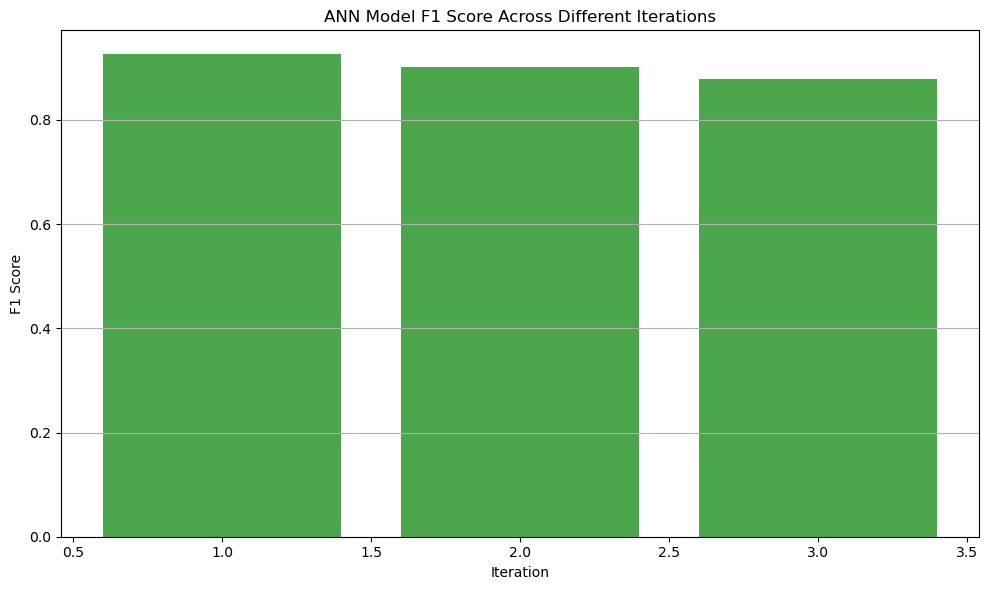

In [27]:
# Define the sets of parameters
params = [
    # Iteration 1 set
    [
      (Adam(learning_rate=0.1), 80),
      (SGD(learning_rate=0.1), 80)
    ],
    # Iteration 2 set
    [
      (Adam(learning_rate=0.001), 90),
      (Adam(learning_rate=0.01), 90),
      (Adam(learning_rate=0.001), 100),
      (Adam(learning_rate=0.01), 100),
      (SGD(learning_rate=0.001), 90),
      (SGD(learning_rate=0.01), 90),
      (SGD(learning_rate=0.001), 100),
      (SGD(learning_rate=0.01), 100)
    ],
    # Iteration 3 set
    [
      (Adam(learning_rate=0.001), 80),
      (Adam(learning_rate=0.001), 100),
      (SGD(learning_rate=0.001), 80),
      (SGD(learning_rate=0.001), 100)
    ]
]
 
# Store the scores for each iteration
highest_scores_per_iteration = []
iteration_count = 1
 
for param_set in params:
  highest_f1 = -1 # Initialize the highest f1 score
  for i, (optimizer, epoch) in enumerate(param_set):
      accuracy, precision, recall, f1 = buildModel(optimizer, epoch)
      if(f1 > highest_f1): # Set the highest score based on f1 score
        iteration_highest = {
            "Iteration": iteration_count,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        }
  highest_scores_per_iteration.append(iteration_highest) # Add the highest scores in the iteration
  iteration_count+=1
 
# Print the highest param set in each iteration
for highest_param_set in highest_scores_per_iteration:
  print("Iteration: ", highest_param_set['Iteration'])
  print(f"Accuracy: {highest_param_set['Accuracy']:.4f}")
  print(f"Precision: {highest_param_set['Precision']:.4f}")
  print(f"Recall: {highest_param_set['Recall']:.4f}")
  print(f"F1 Score: {highest_param_set['F1 Score']:.4f}")
  print()
 
# Plotting the F1 scores across iterations using a bar chart
highest_f1_scores_per_iteration = []
columns = []
for iteration_highest in highest_scores_per_iteration:
  highest_f1_scores_per_iteration.append(iteration_highest["F1 Score"])
  columns.append(iteration_highest["Iteration"])
 
x_col = columns
y_lab = highest_f1_scores_per_iteration
 
plt.figure(figsize=(10, 6))
plt.bar(x_col, y_lab, color='g', alpha=0.7)
 
plt.title('ANN Model F1 Score Across Different Iterations')
plt.xlabel('Iteration')
plt.ylabel('F1 Score')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [30]:
# Add Out of Sample Test Data
test_data = [[70, 1, 0, 242.52, 45.5, True, False, True, False, False, False, False, False]]
test_data = pd.DataFrame(test_data, columns=['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_Male', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_never smoked', 'smoking_status_smokes'])

print(test_data)

# Standardize the data
test_data = scaler.transform(test_data)

   age  hypertension  heart_disease  avg_glucose_level   bmi  gender_Male  \
0   70             1              0             242.52  45.5         True   

   work_type_Never_worked  work_type_Private  work_type_Self-employed  \
0                   False               True                    False   

   work_type_children  Residence_type_Urban  smoking_status_never smoked  \
0               False                 False                        False   

   smoking_status_smokes  
0                  False  


In [31]:
# Make Prediction
y_pred = best_rf_model.predict(test_data)

print("Predicted Result (0 = no stroke, 1 = stroke): ", y_pred[0])

Predicted Result (0 = no stroke, 1 = stroke):  1
